<a href="https://colab.research.google.com/github/aniketDash7/AniketDash/blob/master/CRearthengine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

In [ ]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='ee-crmmn')

In [ ]:
point = ee.Geometry.Point([77.5913, 12.9791])

landsat8 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
    .filterBounds(point)
    .filterDate('2023-01-01', '2023-01-10')
    .first()
)

In [ ]:
print('Landsat 8 Image ID:', landsat8.get('system:id').getInfo())

Landsat 8 Image ID: LANDSAT/LC08/C02/T1_TOA/LC08_144051_20230103


In [ ]:
landsat8 = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_144051_20230103')\
            .select('B4','B3','B2')
#creating a region
#the location must match the landsat data too
region = ee.Geometry.Rectangle(37.07,11.50,37.39,11.82)

In [ ]:
#export to drive
task = ee.batch.Export.image.toDrive(**{
    'image':landsat8,
    #image we want to export
    'description':'testexample',
    'folder':'Example_folder',
    'scale':30,
    #spatial resolution of the data since, here its 30 because of landsat
    'region':region.getInfo()['coordinates']
    #by default it doesn't understand coordinate information so we have to extract it

})
task.start()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

We created a scale factor because the products are stored as integers to save storage space. Most of the products will have scaled factors and offset so we need to convert them to floating point.
We apply scaledfactors to the opticalbands and the thermal bands. Add those corrected bands to the image and return them

In [ ]:
roi = ee.Geometry.Point([38.5914,7.71])
def applyScaleFactors(image):
  opticalBands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
  thermalBands = image.select("ST_B.*").multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands,None,True)\
              .addBands(thermalBands,None,True)

In [ ]:
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
          .filterDate('2017-01-01','2017-12-31')\
          .filterBounds(roi)\
          .map(applyScaleFactors)\
          .sort('CLOUD_COVER')\
          .first()
          #picking the first image as the cloud free image


In [ ]:
ndvi = image.normalizedDifference(['SR_B5','SR_B4']).rename(['ndvi'])

In [ ]:
mndwi = image.normalizedDifference(['SR_B3','SR_B6']).rename(['mndwi'])

ND function generates random name hence the renaming

In [ ]:
images = image.addBands(ndvi).addBands(mndwi)

In [ ]:
visualization = {
    'bands':['SR_B4','SR_B3','SR_B2'],
    'min':0.0,
    'max':0.3,
}

In [ ]:
Map = geemap.Map()
Map.centerObject(image,8)
Map.addLayer(image,visualization,'True Color (432)')

In [ ]:
Map

Map(center=[7.229675915404072, 38.93426311888417], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
#using a preexisting landcover map
lc = ee.ImageCollection('projects/sat-io/open-datasets/landcover/ESRI_Global_LULC-10m_TS')\
      .filterDate('2017-01-01','2017-12-31')\
      .mosaic()\
      .remap([1,2,4,5,7,8,9,10,11],[1,2,3,4,5,6,7,8,9]).rename('lc')

In [ ]:
print(lc.getInfo())

EEException: ImageCollection.load: ImageCollection asset 'projects/sat-io/open-datasets/landcover/ESRI_Global_LULC-10m_TS' not found (does not exist or caller does not have access).

In [ ]:
image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_144051_20230103')  # Example image ID

# Get available band names
band_names = image.bandNames().getInfo()

# Print the band names
print("Available Bands:", band_names)

Available Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA']


#Implementation

In [ ]:
regions = {
    "New South Wales, Australia": ee.Geometry.Rectangle([145.59, -34.24, 146.39, -33.84]),
    "Wuhan, China": ee.Geometry.Rectangle([114.00, 30.50, 114.30, 30.80])
}

In [ ]:
def get_cloud_free_landsat(collection,region,start_date,end_date):
  dataset = ee.ImageCollection(collection)\
              .filterBounds(region)\
              .filterDate(start_date,end_date)\
              .filter(ee.Filter.lt('CLOUD_COVER',5))\
              .select(['B2','B3','B4','B5','QA_PIXEL'])
  return dataset.median().clip(region)

In [ ]:
landsat5_img = get_cloud_free_landsat('LANDSAT/LT05/C02/T1_TOA',regions['New South Wales, Australia'],"2004-11-01","2005-01-30")

In [ ]:
landsat8_img = get_cloud_free_landsat('LANDSAT/LC08/C02/T1_TOA',regions['Wuhan, China'],"2013-05-01","2013-07-30")

In [ ]:
def create_cloud_mask(image):
  qa = image.select("QA_PIXEL").toInt32()
  cloud_mask = qa.bitwiseAnd(1<<5).neq(0)
  #bit 5 indicates clouds
  return cloud_mask

In [ ]:
def apply_cloud_mask(image,region,cloud_cover):
  mask = create_cloud_mask(image)
  masked_image = image.updateMask(mask)
  return masked_image.multiply(cloud_cover).clip(region)

In [ ]:
temporal_1 = apply_cloud_mask(landsat8_img,regions["Wuhan, China"],0.25)

In [ ]:
temporal_2 = apply_cloud_mask(landsat8_img, regions["Wuhan, China"], 0.15)
temporal_3 = apply_cloud_mask(landsat8_img, regions["Wuhan, China"], 0.10)

In [ ]:
def export_to_drive(image,description,folder,region):
  task = ee.batch.Export.image.toDrive(
    image = image,
    description = description,
    folder = folder,
    scale = 30,
    region = region.getInfo()['coordinates'],
    fileFormat = 'GeoTIFF'
  )
  task.start()

In [ ]:
export_to_drive(temporal_1,"Temporal_1_Cloud_25", "Cloud_Dataset", regions['Wuhan, China'])
export_to_drive(temporal_2, "Temporal_2_Cloud_15", "Cloud_Dataset", regions["Wuhan, China"])
export_to_drive(temporal_3, "Temporal_3_Cloud_10", "Cloud_Dataset", regions["Wuhan, China"])

In [ ]:
task_list = ee.batch.Task.list()
for task in task_list[0:3]:
    print(task.status())

{'state': 'COMPLETED', 'description': 'Temporal_3_Cloud_10', 'priority': 100, 'creation_timestamp_ms': 1742331754830, 'update_timestamp_ms': 1742331905125, 'start_timestamp_ms': 1742331868991, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1dNZeCaR0arpemGLJtB-medcaAl47mDUA'], 'attempt': 1, 'batch_eecu_usage_seconds': 12.156394004821777, 'id': 'MWC7RD3D7DKI5DQTPADVAC6G', 'name': 'projects/ee-crmmn/operations/MWC7RD3D7DKI5DQTPADVAC6G'}
{'state': 'COMPLETED', 'description': 'Temporal_2_Cloud_15', 'priority': 100, 'creation_timestamp_ms': 1742331754461, 'update_timestamp_ms': 1742331855574, 'start_timestamp_ms': 1742331817965, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1dNZeCaR0arpemGLJtB-medcaAl47mDUA'], 'attempt': 1, 'batch_eecu_usage_seconds': 6.678910732269287, 'id': '44BY4PJT6OKT4LABZ3MO52JN', 'name': 'projects/ee-crmmn/operations/44BY4PJT6OKT4LABZ3MO52JN'}
{'state': 'COMPLETED', 'description': 'Temporal_1

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.4 MB/s eta 0:00:00


In [ ]:
import rasterio

Image shape: (5, 1488, 2970)


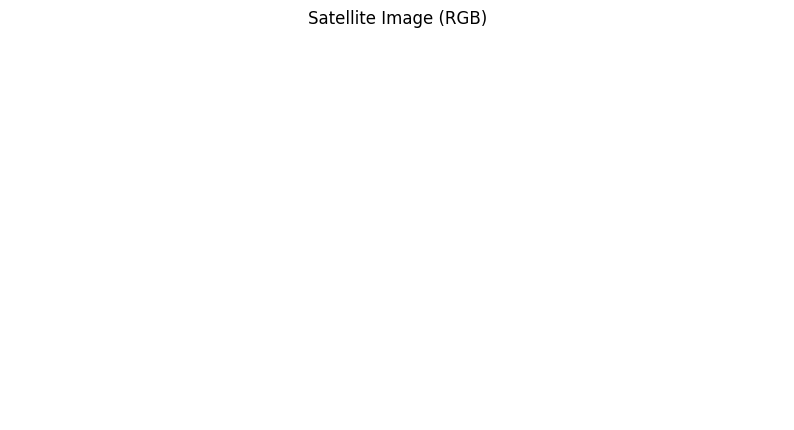

In [ ]:
tiff_path = "/content/drive/MyDrive/CMSN_Dataset/Australia_T1_Cloud_25.tif"  # Update with correct file path

# Open the TIFF file
with rasterio.open(tiff_path) as dataset:
    image = dataset.read()  # Read all bands

# Print image shape (Bands, Height, Width)
print("Image shape:", image.shape)

# Select the RGB bands (assuming B2=Blue, B3=Green, B4=Red)
if image.shape[0] >= 3:
    rgb_image = np.stack([image[2], image[1], image[0]], axis=-1)  # (H, W, 3)

    # Normalize for display
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("Satellite Image (RGB)")
    plt.show()
else:
    print("Not enough bands to display an RGB image.")

🔹 Why is the Image White?
1️⃣ Pixel values are outside the expected range (0–255 for 8-bit images, or 0–1 for normalized display).
2️⃣ No-data values exist but are not being handled properly.
3️⃣ Bands might not be mapped correctly for visualization.

In [ ]:
with rasterio.open(tiff_path) as dataset:
    print("Metadata:", dataset.meta)
    print("CRS:", dataset.crs)  # Coordinate Reference System
    print("Bounds:", dataset.bounds)  # Image extent


Metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1114, 'height': 1115, 'count': 5, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 113.99998247896059,
       0.0, -0.00026949458523585647, 30.8002666520208)}
CRS: EPSG:4326
Bounds: BoundingBox(left=113.99998247896059, bottom=30.49978018948282, right=114.30019944691334, top=30.8002666520208)


No-data value: None
Image shape: (5, 1488, 2970)
Data type: float32
Min pixel value: nan Max pixel value: nan


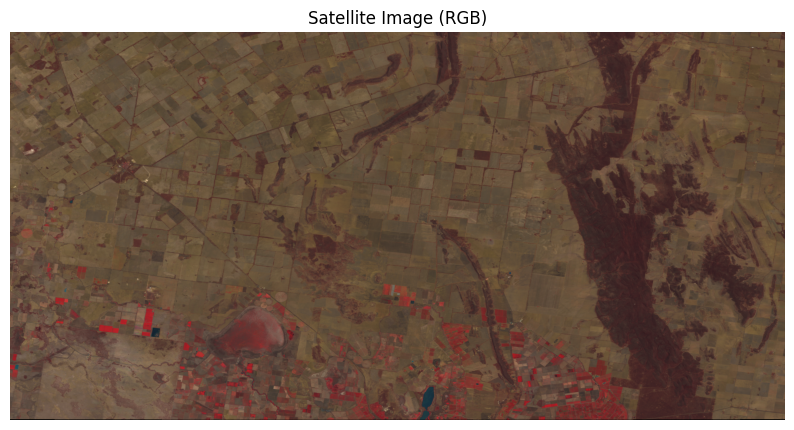

In [ ]:
with rasterio.open(tiff_path) as dataset:
  #reading all the bands
    image = dataset.read()
    nodata_value = dataset.nodata
    print(f"No-data value: {nodata_value}")

print("Image shape:", image.shape)
 # (Bands, Height, Width)
print("Data type:", image.dtype)
print("Min pixel value:", image.min(), "Max pixel value:", image.max())

# Handle no-data values (if they exist)
if nodata_value is not None:
    image[image == nodata_value] = np.nan  # Replace no-data with NaN for visualization

# Normalize image values for display
image = np.nan_to_num(image)  # Replace NaNs with zeros

# Select RGB bands (assuming B2=Blue, B3=Green, B4=Red)
if image.shape[0] >= 3:
    rgb_image = np.stack([image[2], image[1], image[0]], axis=-1)  # Convert to (H, W, 3)

    # Normalize to [0, 1] range
    rgb_image = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image) + 1e-8)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.title("Satellite Image (RGB)")
    plt.show()
else:
    print("Not enough bands to display an RGB image.")

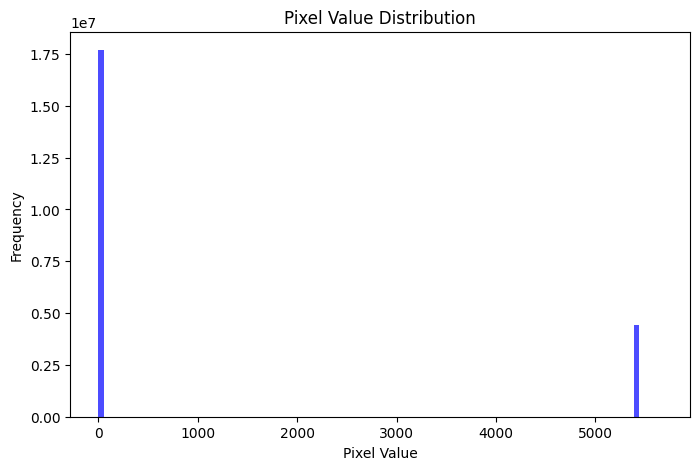

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of pixel values
plt.figure(figsize=(8, 5))
plt.hist(image.flatten(), bins=100, color="blue", alpha=0.7)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Pixel Value Distribution")
plt.show()


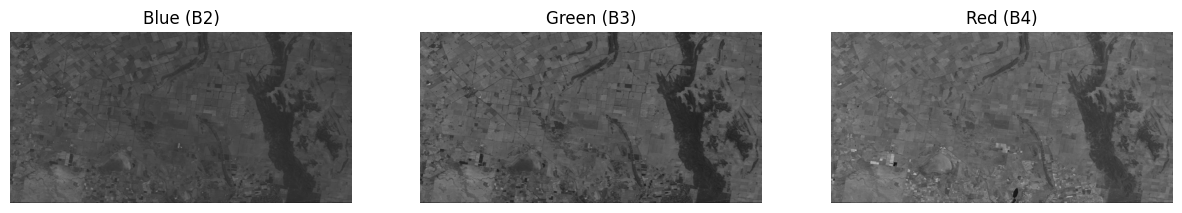

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
bands = ["Blue (B2)", "Green (B3)", "Red (B4)"]

for i, ax in enumerate(axes):
    ax.imshow(image[i], cmap="gray")  # Display each band in grayscale
    ax.set_title(bands[i])
    ax.axis("off")

plt.show()

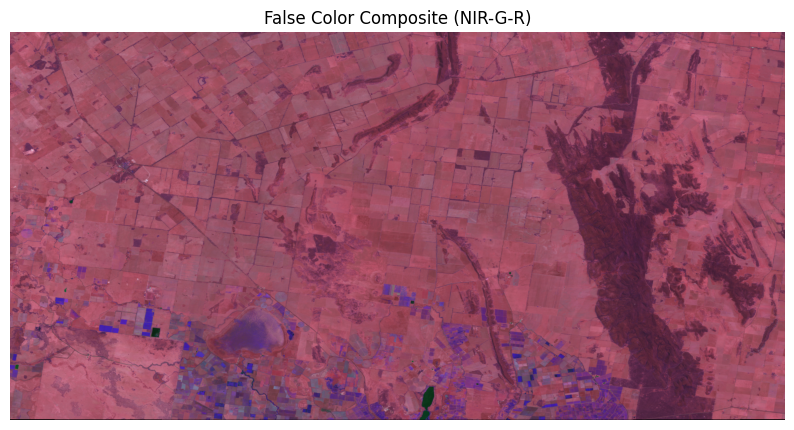

In [ ]:
if image.shape[0] >= 3:
    false_color = np.stack([image[3], image[1], image[2]], axis=-1)  # (H, W, 3)

    # Normalize to [0, 1] for display
    false_color = (false_color - np.nanmin(false_color)) / (np.nanmax(false_color) - np.nanmin(false_color) + 1e-8)

    # Display False Color Image
    plt.figure(figsize=(10, 10))
    plt.imshow(false_color)
    plt.axis("off")
    plt.title("False Color Composite (NIR-G-R)")
    plt.show()

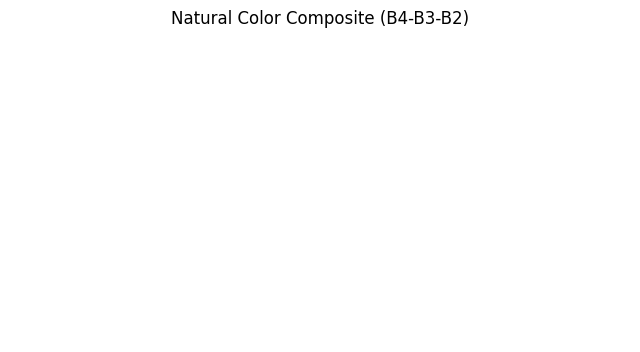

In [ ]:
with rasterio.open(tiff_path) as src:
    red = src.read(4).astype(np.float32)  # Band 4 (Red)
    green = src.read(3).astype(np.float32)  # Band 3 (Green)
    blue = src.read(2).astype(np.float32)  # Band 2 (Blue)

# Normalize pixel values to 0-1 for visualization
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

red = normalize(red)
green = normalize(green)
blue = normalize(blue)

# Stack bands into an RGB image
rgb_image = np.dstack((red, green, blue))

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Natural Color Composite (B4-B3-B2)")
plt.show()

#Pipeline attempt : 2

In [ ]:

# Define regions
regions = {
    "New South Wales, Australia": ee.Geometry.Rectangle([145.59, -34.24, 146.39, -33.84]),
    "Wuhan, China": ee.Geometry.Rectangle([114.00, 30.50, 114.30, 30.80])
}

def get_landsat_images(collection, region, start_date, end_date):
    """Retrieve cloud-free Landsat images with selected bands."""
    return (ee.ImageCollection(collection)
              .filterBounds(region)
              .filterDate(start_date, end_date)
              .select(['B2', 'B3', 'B4', 'B5', 'QA_PIXEL'])
           )

def create_cloud_mask(image):
    """Generate a cloud mask using the QA_PIXEL band (bit 5 indicates clouds)."""
    qa = image.select("QA_PIXEL").toInt32()
    cloud_mask = qa.bitwiseAnd(1 << 5).neq(0)  # Bit 5 indicates cloud presence
    return cloud_mask

def apply_cloud_mask(image, region, cloud_fraction):
    """Apply cloud mask and retain a controlled percentage of cloud cover."""
    cloud_mask = create_cloud_mask(image)
    cloud_probability = ee.Image.random().lt(cloud_fraction)  # Randomly apply clouds
    final_mask = cloud_mask.And(cloud_probability)
    return image.updateMask(final_mask.Not()).clip(region).toFloat()  # Convert all bands to Float32

def process_dataset(region_name, collection, start_date, end_date):
    """Extract and generate three-temporal images with controlled cloud cover."""
    region = regions[region_name]
    landsat_images = get_landsat_images(collection, region, start_date, end_date)
    median_image = landsat_images.median().toFloat()  # Convert to Float32

    # Apply cloud masking with specific cloud coverage levels
    t1 = apply_cloud_mask(median_image, region, 0.25)  # 20%-30%
    t2 = apply_cloud_mask(median_image, region, 0.15)  # 10%-20%
    t3 = apply_cloud_mask(median_image, region, 0.10)  # 5%-15%

    return t1, t2, t3

def export_to_drive(image, description, folder, region):
    """Export an image to Google Drive as GeoTIFF."""
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=30,
        region=region,
        fileFormat='GeoTIFF',
        maxPixels=1e13  # Prevent export size errors
    )
    task.start()
    print(f"Exporting {description} to Google Drive...")

# Process datasets
landsat5_t1, landsat5_t2, landsat5_t3 = process_dataset(
    "New South Wales, Australia", 'LANDSAT/LT05/C02/T1_TOA', "2004-11-01", "2005-01-30"
)
landsat8_t1, landsat8_t2, landsat8_t3 = process_dataset(
    "Wuhan, China", 'LANDSAT/LC08/C02/T1_TOA', "2013-05-01", "2013-07-30"
)

# Export images to Google Drive
export_to_drive(landsat5_t1, "Australia_T1_Cloud_25", "CMSN_Dataset", regions["New South Wales, Australia"])
export_to_drive(landsat5_t2, "Australia_T2_Cloud_15", "CMSN_Dataset", regions["New South Wales, Australia"])
export_to_drive(landsat5_t3, "Australia_T3_Cloud_10", "CMSN_Dataset", regions["New South Wales, Australia"])

export_to_drive(landsat8_t1, "Wuhan_T1_Cloud_25", "CMSN_Dataset", regions["Wuhan, China"])
export_to_drive(landsat8_t2, "Wuhan_T2_Cloud_15", "CMSN_Dataset", regions["Wuhan, China"])
export_to_drive(landsat8_t3, "Wuhan_T3_Cloud_10", "CMSN_Dataset", regions["Wuhan, China"])


Exporting Australia_T1_Cloud_25 to Google Drive...
Exporting Australia_T2_Cloud_15 to Google Drive...
Exporting Australia_T3_Cloud_10 to Google Drive...
Exporting Wuhan_T1_Cloud_25 to Google Drive...
Exporting Wuhan_T2_Cloud_15 to Google Drive...
Exporting Wuhan_T3_Cloud_10 to Google Drive...


In [ ]:
task_list = ee.batch.Task.list()
for task in task_list[0:6]:
    print(task.status())

{'state': 'READY', 'description': 'Wuhan_T3_Cloud_10', 'priority': 100, 'creation_timestamp_ms': 1742405890909, 'update_timestamp_ms': 1742405906393, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'NHAN6AKFGCIN2H3FJN7ORQ5I', 'name': 'projects/ee-crmmn/operations/NHAN6AKFGCIN2H3FJN7ORQ5I'}
{'state': 'READY', 'description': 'Wuhan_T2_Cloud_15', 'priority': 100, 'creation_timestamp_ms': 1742405890488, 'update_timestamp_ms': 1742405906428, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'EYJAUQQTHDHLNGO6CHDHMGRA', 'name': 'projects/ee-crmmn/operations/EYJAUQQTHDHLNGO6CHDHMGRA'}
{'state': 'READY', 'description': 'Wuhan_T1_Cloud_25', 'priority': 100, 'creation_timestamp_ms': 1742405890028, 'update_timestamp_ms': 1742405906384, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'J4XBIHBE7LHOT4QVKNHLROVL', 'name': 'projects/ee-crmmn/operations/J4XBIHBE7LHOT4QVKNHLROVL'}
{'state': 'READY', 'description': 'Australia_T3_Cloud_10', 'priority': 100, 'creation_times

In [ ]:
import torch
import torch.nn as nn
import torch.fft
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from torchvision import transforms
from PIL import Image

In [ ]:
class ResFFTConv(nn.Module):
    """Residual FFT-Convolution Block for frequency-based reconstruction."""
    def __init__(self, in_channels, out_channels):
        super(ResFFTConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        fft_x = torch.fft.fft2(x, norm='ortho').real  # Extract real part
        out = F.relu(self.conv1(fft_x))
        out = self.conv2(out)
        return F.relu(out + self.skip(fft_x))

class MFAM(nn.Module):
    """Multi-temporal Fusion Attention Module."""
    def __init__(self, channels):
        super(MFAM, self).__init__()
        self.conv1 = nn.Conv2d(channels * 3, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x1, x2, x3):
        fused = torch.cat([x1, x2, x3], dim=1)
        attn = F.relu(self.conv1(fused))
        return F.relu(self.conv2(attn))

class CMSN(nn.Module):
    """Coarse-to-Refined Multi-temporal Synchronous Cloud Removal Network."""
    def __init__(self, in_channels=4, features=64):
        super(CMSN, self).__init__()
        self.encoder1 = ResFFTConv(in_channels, features)
        self.encoder2 = ResFFTConv(features, features * 2)
        self.mfam = MFAM(features * 2)
        self.decoder = nn.Conv2d(features * 2, in_channels, kernel_size=3, padding=1)
        self.refine_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, t1, t2, t3):
        e1 = self.encoder1(t1)
        e2 = self.encoder2(e1)
        fused = self.mfam(e2, e2, e2)
        coarse_out = self.decoder(fused)
        refined_out = self.refine_conv(coarse_out)
        return refined_out

In [ ]:
class CMSNDataset(Dataset):
    """Loads CMSN-style dataset with multi-temporal patches (No Ground Truth)."""
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = self._load_samples()

    def _load_samples(self):
        files = sorted(os.listdir(self.root_dir))
        t1_files = [f for f in files if 'T1' in f]
        t2_files = [f for f in files if 'T2' in f]
        t3_files = [f for f in files if 'T3' in f]
        return list(zip(t1_files, t2_files, t3_files))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t1_path, t2_path, t3_path = [os.path.join(self.root_dir, f) for f in self.samples[idx]]
        t1, t2, t3 = [self._load_image(p) for p in [t1_path, t2_path, t3_path]]
        return t1, t2, t3

    def _load_image(self, path):
        with rasterio.open(path) as src:
            img = src.read(out_dtype='float32')  # Read all bands

        img = torch.tensor(img[:4])
        img = T.Resize((256, 256))(img) # Select only the first 4 bands (B2, B3, B4, B5)
        return img

In [ ]:
# def fft_loss(pred, target):
#     """Frequency reconstruction loss using FFT."""
#     return F.l1_loss(torch.fft.fft2(pred).real, torch.fft.fft2(target).real)

# def global_local_loss(pred, target):
#     """Global-local L1 loss."""
#     return F.l1_loss(pred, target)


In [ ]:
def train_cmsn(model, dataloader, epochs=50, lr=3e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    for epoch in range(epochs):
        for t1, t2, t3 in dataloader:
            t1, t2, t3 = t1.to(device), t2.to(device), t3.to(device)
            optimizer.zero_grad()
            output = model(t1, t2, t3)
            loss = torch.tensor(0.0, requires_grad=True)  # Placeholder loss (No GT)
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} completed.")

    print("Training complete!")

In [ ]:
    dataset = CMSNDataset(root_dir="/content/drive/MyDrive/CMSN_Dataset")
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    model = CMSN()
    train_cmsn(model, dataloader)

Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.
Epoch 7/50 completed.
Epoch 8/50 completed.
Epoch 9/50 completed.
Epoch 10/50 completed.
Epoch 11/50 completed.
Epoch 12/50 completed.
Epoch 13/50 completed.
Epoch 14/50 completed.
Epoch 15/50 completed.
Epoch 16/50 completed.
Epoch 17/50 completed.
Epoch 18/50 completed.
Epoch 19/50 completed.
Epoch 20/50 completed.
Epoch 21/50 completed.
Epoch 22/50 completed.
Epoch 23/50 completed.
Epoch 24/50 completed.
Epoch 25/50 completed.
Epoch 26/50 completed.
Epoch 27/50 completed.
Epoch 28/50 completed.
Epoch 29/50 completed.
Epoch 30/50 completed.
Epoch 31/50 completed.
Epoch 32/50 completed.
Epoch 33/50 completed.
Epoch 34/50 completed.
Epoch 35/50 completed.
Epoch 36/50 completed.
Epoch 37/50 completed.
Epoch 38/50 completed.
Epoch 39/50 completed.
Epoch 40/50 completed.
Epoch 41/50 completed.
Epoch 42/50 completed.
Epoch 43/50 completed.
Epoch 44/50 complete

In [ ]:
/content/drive/MyDrive/CMSN_Dataset/Wuhan_T3_Cloud_10.tif
/content/drive/MyDrive/CMSN_Dataset/Wuhan_T1_Cloud_25.tif

In [ ]:
def visualize_results(t1, t2, t3, output):
    """Visualize input images vs. model output."""
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    def show(ax, img, title):
        ax.imshow(img[0].cpu().numpy(), cmap='gray')  # Show first channel (Blue)
        ax.set_title(title)
        ax.axis('off')
    show(axes[0], t1, "T1 Cloudy")
    show(axes[1], t2, "T2 Cloudy")
    show(axes[2], t3, "T3 Cloudy")
    show(axes[3], output, "CMSN Output")
    plt.show()

In [ ]:
def compute_fft_similarity(img1, img2):
    """Compare FFT magnitudes of two images."""
    fft1 = torch.fft.fft2(img1).abs()
    fft2 = torch.fft.fft2(img2).abs()
    return F.l1_loss(fft1, fft2).item()

In [ ]:
def compute_ndvi(img):
    """Compute NDVI from NIR (B5) and Red (B4)."""
    nir, red = img[3], img[2]  # B5 (NIR), B4 (Red)
    ndvi = (nir - red) / (nir + red + 1e-8)  # Avoid division by zero
    return ndvi.mean().item()

In [ ]:
dataset

In [ ]:
def evaluate_model(model, dataset):
    model.eval()
    with torch.no_grad():
        for i in range(3):  # Show 3 samples
            t1, t2, t3 = dataset[i]
            output = model(t1.unsqueeze(0), t2.unsqueeze(0), t3.unsqueeze(0)).squeeze(0)
            visualize_results(t1, t2, t3, output)
            print(f"FFT Similarity: {compute_fft_similarity(t1, output):.4f}")
            print(f"NDVI Before: {compute_ndvi(t1):.4f}, After: {compute_ndvi(output):.4f}\n")

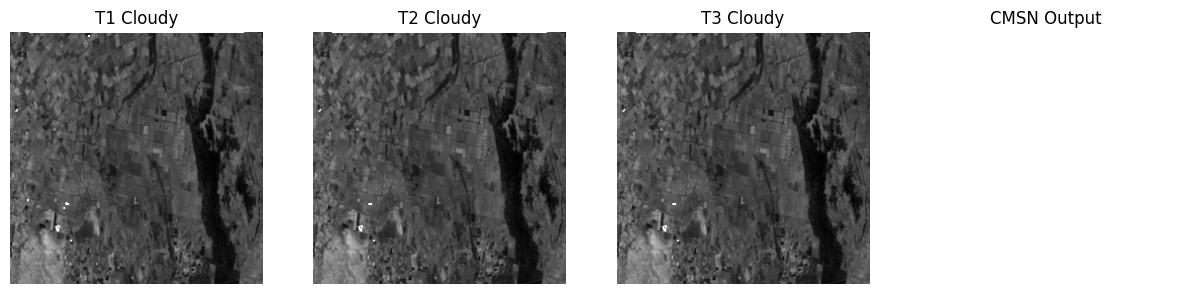

FFT Similarity: nan
NDVI Before: nan, After: nan



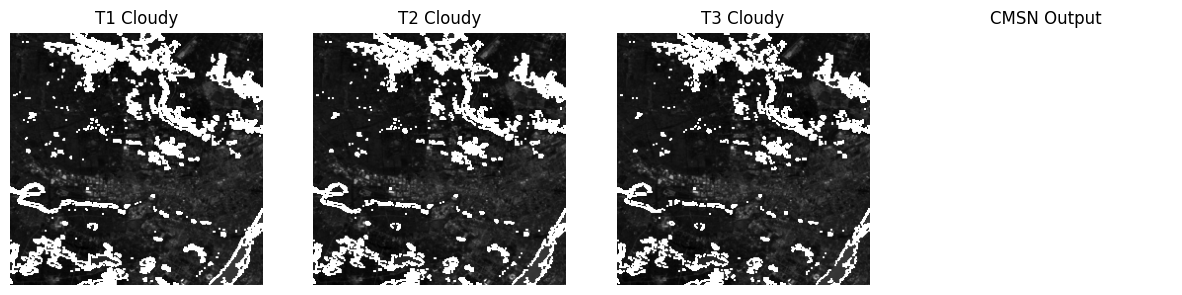

FFT Similarity: nan
NDVI Before: nan, After: nan



IndexError: list index out of range

In [ ]:
evaluate_model(model,dataset)